# Import statements

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import random
import os, sys

# import keras
import keras
from keras import backend as K
backend_keras = keras.backend.backend()
print("keras is using", backend_keras, "as the backend")
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model, Sequential

# optimizers 
from keras.optimizers import SGD, Nadam, Adamax, Adam, Adadelta, Adagrad, RMSprop


keras is using tensorflow as the backend


# Load redshift data and labels
These are the ones which have been created with the keras notebook

In [13]:
f = os.listdir()
f.sort()
for i in f: print(i)

.ipynb_checkpoints
CNN3_classify_redshift_with_autoencoder.ipynb
CNN4_classify_esc_frac_direct_cnn.ipynb
CNN4_classify_esc_frac_with_autoencoder.ipynb
CNN5_classify_redshift_direct_cnn.ipynb
big_mix_data_6528.npy
big_mix_labels_6528.npy
data_test.npy
data_train.npy
data_val.npy
labels_test.npy
labels_train.npy
labels_val.npy
preprocessing.ipynb


In [18]:
# load data
x_train_raw = np.load("data_train.npy")
x_val_raw = np.load("data_val.npy")
x_test_raw = np.load("data_test.npy")

# load labels
labels_train = np.load("labels_train.npy",allow_pickle=True)
labels_val = np.load("labels_val.npy",allow_pickle=True)
labels_test = np.load("labels_test.npy",allow_pickle=True)

# we only care about the redshift labels here
lab_red_train = np.array([i[1] for i in labels_train])
lab_red_val = np.array([i[1] for i in labels_val])
lab_red_test = np.array([i[1] for i in labels_test])

print("shapes :", x_train_raw.shape, x_val_raw.shape, x_test_raw.shape)
print("more shape :", lab_red_train.shape, lab_red_val.shape, lab_red_test.shape)

shapes : (4896, 200, 200, 1) (652, 200, 200, 1) (980, 200, 200, 1)
more shape : (4896, 17) (652, 17) (980, 17)


# Apply Autoencoder
## first load the autoencoder

In [21]:
os.listdir("../../Auto-Encoder Training/")
autoencoder = load_model("../../Auto-Encoder Training/autoencoder_adam_95.model")

In [22]:
#autoencoder.summary()
encoder = Model(autoencoder.input, autoencoder.layers[-8].output)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 8)       1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 8)         0   

In [23]:
x_train = encoder.predict(x_train_raw)
x_val = encoder.predict(x_val_raw)
x_test = encoder.predict(x_test_raw)

# Define the CNN architecture

In [35]:
classifier = Sequential()

# extract features
classifier.add(Conv2D(16, (3,3), input_shape=(25,25,8),
                     activation='relu', padding='valid'))
# reduce dimensionality, keep most important info
classifier.add(MaxPooling2D(pool_size=(2,2)))

# add a second layer, again with no padding
classifier.add(Conv2D(8, (3,3), activation='relu', padding='valid'))

# pool again
classifier.add(MaxPooling2D(pool_size=(2,2)))

# here i flatten and then guess the class
classifier.add(Flatten())

# fully connected layers ensures connections to all activations 
# in previous layers

classifier.add(Dense(units=17, activation='softmax'))

# Alternative Architecutre

# Hyper params + compile netowrk

In [38]:
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,
          amsgrad=True)

classifier.compile(optimizer=opt,
                   loss='categorical_crossentropy',
                   metrics=["accuracy"])
print("printing summary of model")
classifier.summary()

printing summary of model
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 23, 23, 16)        1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 9, 8)           1160      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 17)                2193      
Total params: 4,521
Trainable params: 4,521
Non-trainable params: 0
__________________________

# Train the network

In [39]:
print(x_train.shape, lab_red_train.shape)

(4896, 25, 25, 8) (4896, 17)


# Display netowrk stats and save plots

In [40]:
EPOCHS = 250

H = classifier.fit(x_train, lab_red_train,
                  epochs = EPOCHS,
                  batch_size = 128,
                  shuffle = True,
                  validation_data=(x_val, lab_red_val))

Train on 4896 samples, validate on 652 samples
Epoch 1/250
4896/4896 [==============================] - 1s 224us/step - loss: 2.8092 - accuracy: 0.0956 - val_loss: 2.6696 - val_accuracy: 0.1104
Epoch 2/250
4896/4896 [==============================] - 1s 199us/step - loss: 2.3892 - accuracy: 0.1183 - val_loss: 2.1575 - val_accuracy: 0.1564
Epoch 3/250
4896/4896 [==============================] - 1s 206us/step - loss: 1.8998 - accuracy: 0.2516 - val_loss: 1.7028 - val_accuracy: 0.3589
Epoch 4/250
4896/4896 [==============================] - 1s 200us/step - loss: 1.5313 - accuracy: 0.4383 - val_loss: 1.4124 - val_accuracy: 0.4540
Epoch 5/250
4896/4896 [==============================] - 1s 192us/step - loss: 1.2979 - accuracy: 0.5088 - val_loss: 1.2357 - val_accuracy: 0.5276
Epoch 6/250
4896/4896 [==============================] - 1s 193us/step - loss: 1.1582 - accuracy: 0.5684 - val_loss: 1.1314 - val_accuracy: 0.5859
Epoch 7/250
4896/4896 [==============================] - 1s 201us/step 

4896/4896 [==============================] - 1s 292us/step - loss: 0.5390 - accuracy: 0.7574 - val_loss: 0.5697 - val_accuracy: 0.7546
Epoch 57/250
4896/4896 [==============================] - 1s 288us/step - loss: 0.5523 - accuracy: 0.7529 - val_loss: 0.5327 - val_accuracy: 0.7607
Epoch 58/250
4896/4896 [==============================] - 1s 290us/step - loss: 0.5389 - accuracy: 0.7623 - val_loss: 0.5771 - val_accuracy: 0.7561
Epoch 59/250
4896/4896 [==============================] - 1s 300us/step - loss: 0.5420 - accuracy: 0.7535 - val_loss: 0.5486 - val_accuracy: 0.7684
Epoch 60/250
4896/4896 [==============================] - 1s 289us/step - loss: 0.5443 - accuracy: 0.7600 - val_loss: 0.5568 - val_accuracy: 0.7607
Epoch 61/250
4896/4896 [==============================] - 1s 286us/step - loss: 0.5385 - accuracy: 0.7559 - val_loss: 0.5441 - val_accuracy: 0.7423
Epoch 62/250
4896/4896 [==============================] - 1s 293us/step - loss: 0.5358 - accuracy: 0.7486 - val_loss: 0.5234 

4896/4896 [==============================] - 2s 313us/step - loss: 0.4734 - accuracy: 0.7835 - val_loss: 0.4652 - val_accuracy: 0.8037
Epoch 112/250
4896/4896 [==============================] - 1s 291us/step - loss: 0.4624 - accuracy: 0.7855 - val_loss: 0.4897 - val_accuracy: 0.7730
Epoch 113/250
4896/4896 [==============================] - 1s 296us/step - loss: 0.4673 - accuracy: 0.7833 - val_loss: 0.4651 - val_accuracy: 0.7899
Epoch 114/250
4896/4896 [==============================] - 1s 299us/step - loss: 0.4534 - accuracy: 0.7853 - val_loss: 0.4714 - val_accuracy: 0.7960
Epoch 115/250
4896/4896 [==============================] - 1s 293us/step - loss: 0.4477 - accuracy: 0.7921 - val_loss: 0.4592 - val_accuracy: 0.7868
Epoch 116/250
4896/4896 [==============================] - 1s 298us/step - loss: 0.4508 - accuracy: 0.7853 - val_loss: 0.4533 - val_accuracy: 0.7761
Epoch 117/250
4896/4896 [==============================] - 2s 311us/step - loss: 0.4650 - accuracy: 0.7780 - val_loss: 0

4896/4896 [==============================] - 1s 298us/step - loss: 0.4055 - accuracy: 0.8011 - val_loss: 0.4131 - val_accuracy: 0.8129
Epoch 167/250
4896/4896 [==============================] - 2s 318us/step - loss: 0.4089 - accuracy: 0.8168 - val_loss: 0.4206 - val_accuracy: 0.8052
Epoch 168/250
4896/4896 [==============================] - 2s 313us/step - loss: 0.4087 - accuracy: 0.8094 - val_loss: 0.4297 - val_accuracy: 0.8282
Epoch 169/250
4896/4896 [==============================] - 1s 305us/step - loss: 0.4034 - accuracy: 0.8096 - val_loss: 0.4589 - val_accuracy: 0.7807
Epoch 170/250
4896/4896 [==============================] - 1s 296us/step - loss: 0.4118 - accuracy: 0.8070 - val_loss: 0.4373 - val_accuracy: 0.7960
Epoch 171/250
4896/4896 [==============================] - 1s 296us/step - loss: 0.4032 - accuracy: 0.8098 - val_loss: 0.4112 - val_accuracy: 0.8144
Epoch 172/250
4896/4896 [==============================] - 1s 286us/step - loss: 0.4002 - accuracy: 0.8121 - val_loss: 0

4896/4896 [==============================] - 1s 287us/step - loss: 0.3676 - accuracy: 0.8301 - val_loss: 0.4221 - val_accuracy: 0.8206
Epoch 222/250
4896/4896 [==============================] - 1s 304us/step - loss: 0.3630 - accuracy: 0.8307 - val_loss: 0.3702 - val_accuracy: 0.8282
Epoch 223/250
4896/4896 [==============================] - 1s 295us/step - loss: 0.3759 - accuracy: 0.8203 - val_loss: 0.3898 - val_accuracy: 0.8144
Epoch 224/250
4896/4896 [==============================] - 1s 296us/step - loss: 0.3763 - accuracy: 0.8266 - val_loss: 0.3995 - val_accuracy: 0.8221
Epoch 225/250
4896/4896 [==============================] - 1s 288us/step - loss: 0.3651 - accuracy: 0.8256 - val_loss: 0.3712 - val_accuracy: 0.8359
Epoch 226/250
4896/4896 [==============================] - 1s 300us/step - loss: 0.3677 - accuracy: 0.8288 - val_loss: 0.3873 - val_accuracy: 0.8129
Epoch 227/250
4896/4896 [==============================] - 1s 302us/step - loss: 0.3652 - accuracy: 0.8329 - val_loss: 0

# Evaluate the network - display netowork stats and save plots

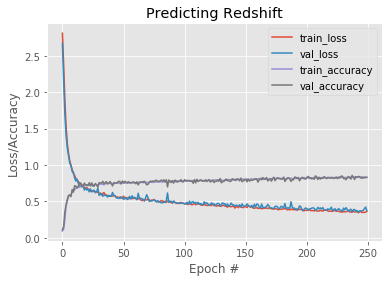

In [47]:
# plot the training loss and accuracy for each epoch
N = np.arange(0,EPOCHS)
plt.figure()
plt.style.use("ggplot")
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_accuracy")
plt.plot(N, H.history["val_accuracy"], label="val_accuracy")
plt.title("Predicting Redshift")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("training_perf_250_arch_03.0_pred_redshift_with_encoder.png")
plt.show()

# Save the weights

In [48]:
classifier.save("keras_arch_03.0_with_encoder_redshift_predict.model")

# Make prediction

In [49]:
pred = classifier.predict(x_test)
print(pred.shape, lab_red_test.shape)
l = len(pred)

(980, 17) (980, 17)


In [54]:
right,wrong = 0,0
for i in range(len(pred)):
    if pred[i].all()==lab_red_test[i].all(): right+=1
    else: wrong+=1
count = right+wrong

In [52]:
print("percentage correctly classified\n",
     100.0*float(right)/count)

percentage correctly classified
 100.0
